In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.show()
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("Set2")

In [ ]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

column_names = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
    'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
] + [f'Wilderness_Area_{i}' for i in range(1, 5)] \
  + [f'Soil_Type_{i}' for i in range(1, 41)] + ['Cover_Type']

df = pd.read_csv(url, header=None, names=column_names, compression='gzip')
print(df.shape)
df.head()


(581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
# Check for missing values
print("Missing values in target variable:", df['Cover_Type'].isnull().sum())

# If there are missing values in the target, we need to handle them
if df['Cover_Type'].isnull().sum() > 0:
    print("Removing rows with missing target values...")
    df = df.dropna(subset=['Cover_Type'])

# Check for missing values in features and handle them
print("Missing values in features:", df.drop('Cover_Type', axis=1).isnull().sum().sum())

if df.drop('Cover_Type', axis=1).isnull().sum().sum() > 0:
    print("Handling missing values in features...")
    # For numerical features, fill with median
    numerical_features = [
        'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points'
    ]

    for feature in numerical_features:
        if df[feature].isnull().sum() > 0:
            df[feature].fillna(df[feature].median(), inplace=True)

    # For binary features (Wilderness_Area and Soil_Type), fill with 0
    binary_features = [f'Wilderness_Area_{i}' for i in range(1, 5)] + [f'Soil_Type_{i}' for i in range(1, 41)]
    for feature in binary_features:
        if df[feature].isnull().sum() > 0:
            df[feature].fillna(0, inplace=True)

Missing values in target variable: 0
Missing values in features: 0


In [ ]:
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Verify no NaN values remain
print("NaN values in X:", X.isnull().sum().sum())
print("NaN values in y:", y.isnull().sum())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Adjust target variable to be zero-indexed for XGBoost
y_train = y_train - 1
y_test = y_test - 1

# Scale the numerical features
numerical_features = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

NaN values in X: 0
NaN values in y: 0
Training set shape: (464809, 54)
Testing set shape: (116203, 54)


In [ ]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
Accuracy: 0.953271430169617

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     42368
           1       0.95      0.97      0.96     56661
           2       0.94      0.96      0.95      7151
           3       0.92      0.86      0.89       549
           4       0.95      0.77      0.85      1899
           5       0.93      0.89      0.91      3473
           6       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



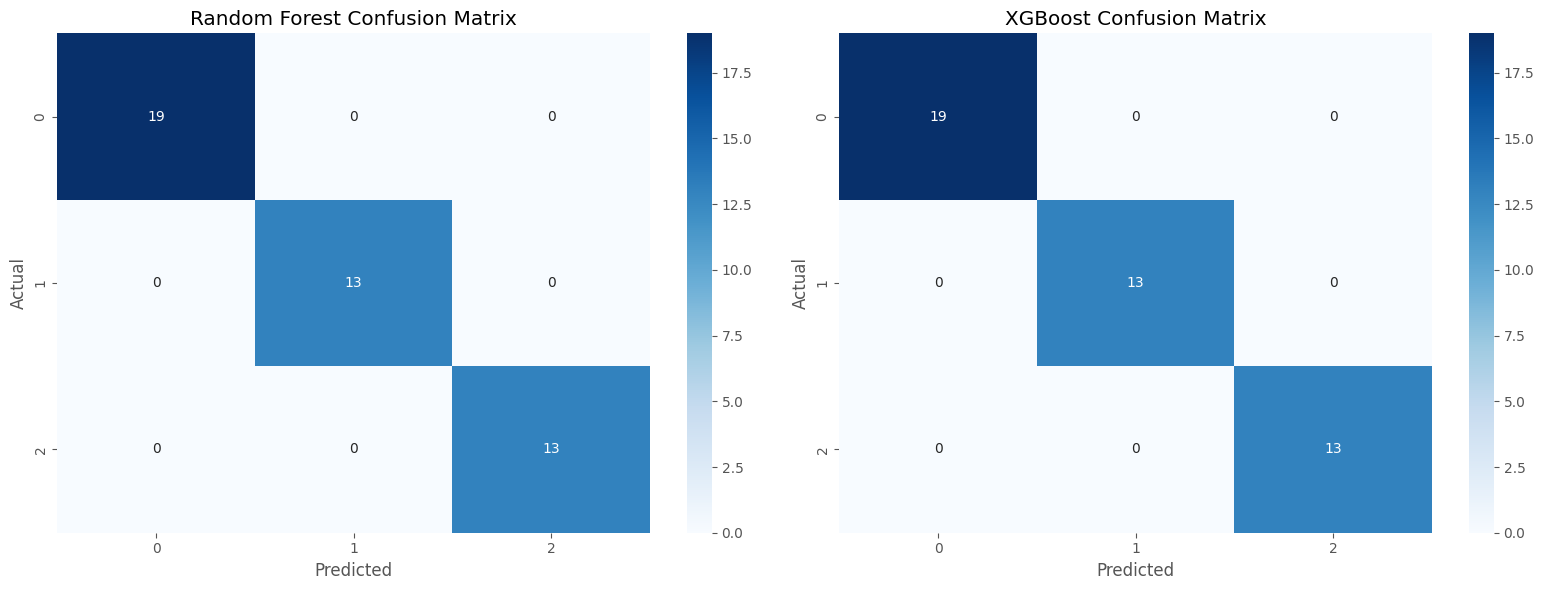

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from xgboost import XGBClassifier

# -----------------------------
# Load example dataset (replace with your dataset)
# -----------------------------
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -----------------------------
# Train Random Forest
# -----------------------------
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# -----------------------------
# Train XGBoost
# -----------------------------
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# -----------------------------
# Plot Confusion Matrices
# -----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('XGBoost Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [ ]:
# Initialize and train XGBoost
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("\nXGBoost Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classifier Results:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



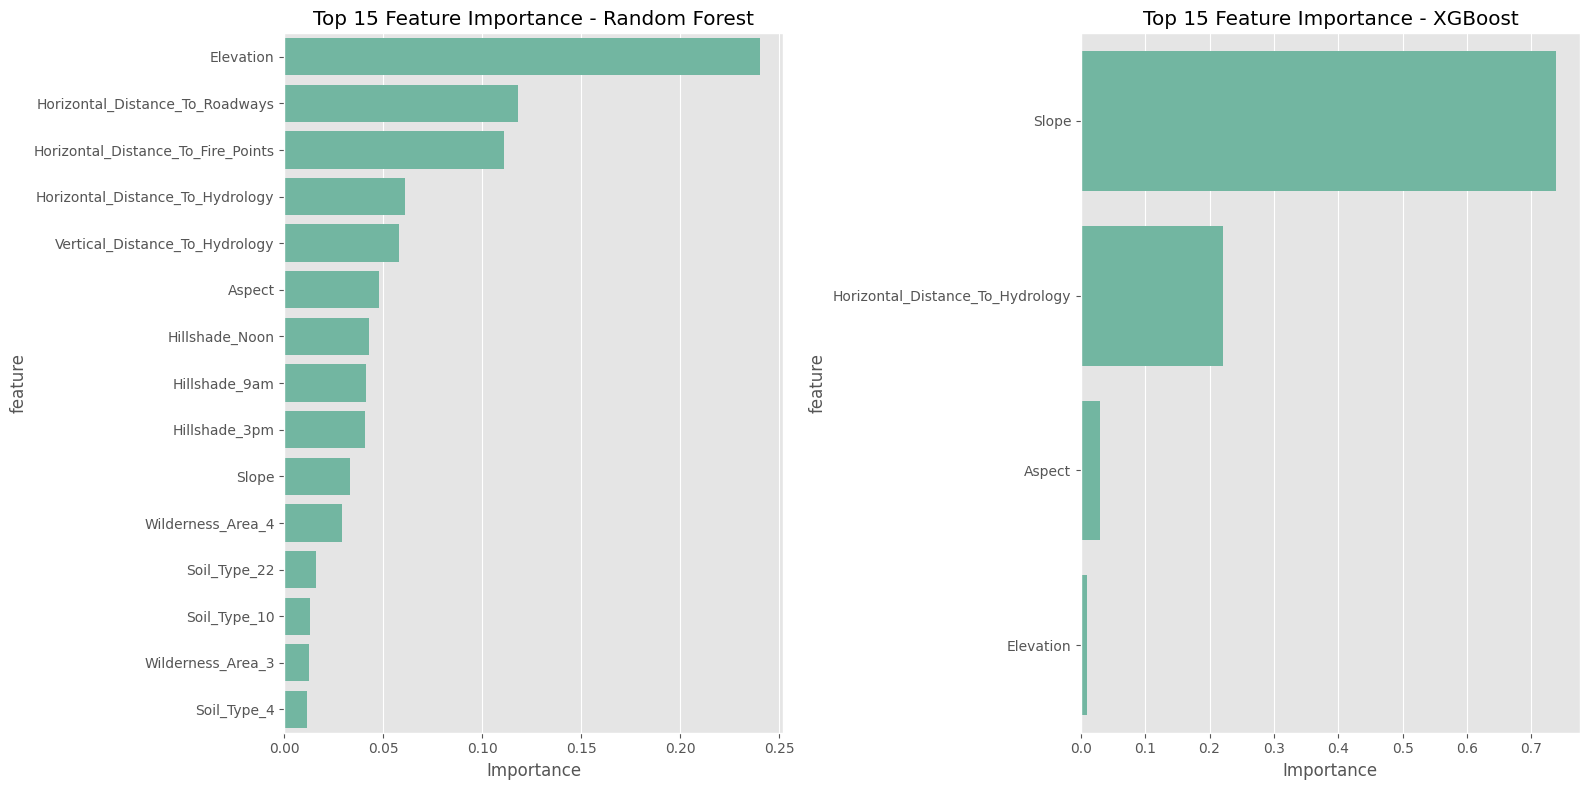

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Match feature names length with model importances
# -----------------------------
def get_feature_importance(model, feature_names):
    # Take min length to avoid mismatch error
    n = min(len(feature_names), len(model.feature_importances_))
    return pd.DataFrame({
        'feature': feature_names[:n],
        'importance': model.feature_importances_[:n]
    }).sort_values('importance', ascending=False)

# Random Forest feature importance
feature_importance_rf = get_feature_importance(rf_model, df.columns.drop('Cover_Type'))

# XGBoost feature importance
feature_importance_xgb = get_feature_importance(xgb_model, df.columns.drop('Cover_Type'))

# -----------------------------
# Plot feature importances
# -----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest feature importance
sns.barplot(x='importance', y='feature', data=feature_importance_rf.head(15), ax=ax1)
ax1.set_title('Top 15 Feature Importance - Random Forest')
ax1.set_xlabel('Importance')

# XGBoost feature importance
sns.barplot(x='importance', y='feature', data=feature_importance_xgb.head(15), ax=ax2)
ax2.set_title('Top 15 Feature Importance - XGBoost')
ax2.set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf, cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Best cross-validation score:", rf_grid.best_score_)

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_grid = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
                        param_grid_xgb, cv=3, n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

print("Best parameters for XGBoost:", xgb_grid.best_params_)
print("Best cross-validation score:", xgb_grid.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.9523809523809524
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best cross-validation score: 0.9333333333333332
